[View in Colaboratory](https://colab.research.google.com/github/alexamies/chinesenotes.com/blob/master/colab/querying_cnotes.ipynb)

# Querying the Chinese Notes Corpus
Query the Chinese Notes corpus based on titles, word frequency, and bigram frequency. First load the 
document and index data into BigQuery using the instructions in the 
[index/README.md](https://github.com/alexamies/chinesenotes.com/blob/master/index/README.md)
file.

## Setup
Setup this sheet for querying the dataset

In [1]:
#project_id = "YOUR PROJECT ID"
project_id = "hbreader-162018"
!gcloud config set project {project_id}

import os
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

from google.colab import auth
auth.authenticate_user()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Updated property [core/project].


## Query Word Frequency
With BM25 document similarity

In [0]:
query = "莫如樹人"
terms = ["莫如","樹", "人"]
bigram = [terms[0] + terms[1], terms[1] + terms[2]]

In [55]:
word_freq_df3u = pd.io.gbq.read_gbq('''
  SELECT
    SUM(2.5 * frequency * idf / (frequency + 1.5)) AS sim_words,
    document
  FROM
    [cnreader.word_freq_doc]
  WHERE
    (word = '%s' OR word = '%s' OR word = '%s')
  GROUP BY document 
  ORDER BY sim_words DESC LIMIT 5000
''' % (terms[0], terms[1], terms[2]), project_id=project_id)
word_freq_df3u.head(5)

,sim_words,document
0,4.011951,zuozhuan/zuozhuan011.html
1,3.676043,songshi/songshi295.html
2,3.654087,zuozhuan/zuozhuan010.html
3,3.622560,guanzi/guanzi004.html
4,3.584419,wenxuan/wenxuan029.html


In [56]:
word_freq_df3u[word_freq_df3u['document'] == 'guanzi/guanzi004.html']

,sim_words,document
3,3.62256,guanzi/guanzi004.html


In [59]:
word_freq_df3u[word_freq_df3u['document'] == 'hanfeizi/hanfeizi033.html']

,sim_words,document
240,1.458261,hanfeizi/hanfeizi033.html


In [60]:
1.458261/3.62256

0.4025498542467206

## Relevance
Exploring the relation between BM25 and relevance

In [3]:
from google.colab import files

uploaded = files.upload()

fname = ""
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  fname = fn


Saving relevance.csv to relevance (1).csv
User uploaded file "relevance.csv" with length 26654 bytes


In [4]:
relevance_df = pd.read_csv(fname,sep='\t',skiprows=(0),header=(0))
relevance_df.head()

,Corpus,Query,Terms,Scoped,Rank,Title,Link,Sim Title,Sim Words,Sim Bigrams,Bit Vector,Relevant
0,chinesenotes.com,箴者，所以攻疾防患,7,False,1,銘箴第十一 Volume 11: Inscriptions and Admonitions,http://chinesenotes.com/wenxin/wenxin011.html,0,1.000000,1.000000,1.0,True
1,chinesenotes.com,箴者，所以攻疾防患,7,False,2,卷三十九 列傳第九 王沈 荀顗 荀勖 馮紞 Volume 39 Biographies 9:...,http://chinesenotes.com/jinshu/jinshu039.html,0,0.817723,0.667315,1.0,False
2,chinesenotes.com,箴者，所以攻疾防患,7,False,3,卷六 Scroll 6,http://chinesenotes.com/wenxuan/wenxuan007.html,0,1.195875,0.343337,1.0,False
3,chinesenotes.com,遠績不辭小,5,False,1,卷二十四 Scroll 24,http://chinesenotes.com/wenxuan/wenxuan025.html,0,1.000000,1.000000,1.0,True
4,chinesenotes.com,遠績不辭小,5,False,2,昭公 Lord Zhao,http://chinesenotes.com/zuozhuan/zuozhuan011.html,0,1.062564,0.486825,1.0,False


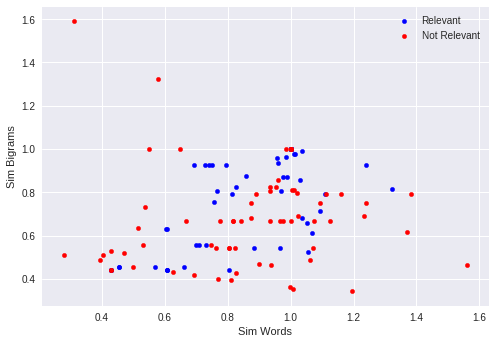

In [7]:
relevant_df = relevance_df[relevance_df['Relevant'] == True]
not_relevant_df = relevance_df[relevance_df['Relevant'] == False]

ax = relevant_df.plot.scatter(x = 'Sim Words', y = 'Sim Bigrams', color='Blue', label='Relevant')
not_relevant_df.plot.scatter(x = 'Sim Words', y = 'Sim Bigrams', color='Red', label='Not Relevant', ax=ax)